# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\poorna\Anaconda3\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')
C:\Users\poorna\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('D:/AAIC/Data_Sets/amazon-fine-food-reviews/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 200000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (200000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(160178, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

80.089

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(160176, 10)


1    134799
0     25377
Name: Score, dtype: int64

In [14]:
#Referred: https://elitedatascience.com/imbalanced-classes
from sklearn.utils import resample

df_majority = final[final.Score==1]
df_minority = final[final.Score==0]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.Score.value_counts()

1    134799
0    134799
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = df_upsampled['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = df_upsampled['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = df_upsampled['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = df_upsampled['Text'].values[4900]
print(sent_4900)
print("="*50)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.
My cat can't get enough of this stuff. I don't understand why there are so many bad reviews for this cat food. My cat is an outdoor cat and comes back for more Whiskas every single day!
This hot sauce is full of flavor and a decent amount of heat. I love the garlic flavors and will purchase again.
Thought this tea would have been more bitter, but it is surprisingly pleasant to drink without sweeteners!  Less bitter than a black or earl grey tea.  The pack of 3 is a wonderful deal as well.  Had to get creative with storing so much tea in my cupboard, but for the amount you get, the price cannot be beat. Highly recomended!


In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.
My cat can't get enough of this stuff. I don't understand why there are so many bad reviews for this cat food. My cat is an outdoor cat and comes back for more Whiskas every single day!
This hot sauce is full of flavor and a decent amount of heat. I love the garlic flavors and will purchase again.
Thought this tea would have been more bitter, but it is surprisingly pleasant to drink without sweeteners!  Less bitter than a black or earl grey tea.  The pack of 3 is a wonderful deal as well.  Had to get creative with storing so much tea in my cupboard, but for the amount you get, the price cannot be beat. Highly recomended!


In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This hot sauce is full of flavor and a decent amount of heat. I love the garlic flavors and will purchase again.


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This hot sauce is full of flavor and a decent amount of heat I love the garlic flavors and will purchase again 


In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(df_upsampled['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████| 269598/269598 [02:14<00:00, 2004.11it/s]


In [24]:
preprocessed_reviews[1500]

'hot sauce full flavor decent amount heat love garlic flavors purchase'

# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [25]:
#divide preprocessed review data to Train and Test dataset using train_test_split
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, Y_train, Y_test = train_test_split(preprocessed_reviews,df_upsampled['Score'].values,test_size=0.3,shuffle=True)
X_train_split, X_CV, Y_train_split, Y_CV = train_test_split(X_train,Y_train,test_size=0.2,shuffle=True)
#print(X_train.shape, Y_tra)
print(pd.DataFrame(Y_train_split)[0].value_counts())
print(pd.DataFrame(Y_CV)[0].value_counts())
print(pd.DataFrame(Y_test)[0].value_counts())

1    75764
0    75210
Name: 0, dtype: int64
0    18878
1    18866
Name: 0, dtype: int64
0    40711
1    40169
Name: 0, dtype: int64


In [26]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train_split)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

X_train_bow_vec = count_vect.transform(X_train_split)
print("the type of count vectorizer ",type(X_train_bow_vec))
print("the shape of out text BOW vectorizer ",X_train_bow_vec.get_shape())
print("the number of unique words ", X_train_bow_vec.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaahhhhhyaaaaaa', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (150974, 60325)
the number of unique words  60325


In [27]:
X_train_bow_vec_full = count_vect.transform(X_train_split)

In [28]:
X_CV_bow_vec = count_vect.transform(X_CV)
X_test_bow_vec = count_vect.transform(X_test)

In [30]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
Y_pred_LSVM_Bow_tr = []
Y_pred_LSVM_Bow_cv = []
Y_pred_LSVM_Bow_test= []
auc_lsvm_bow_tr = []
auc_lsvm_bow_cv = []
auc_lsvm_bow_test = []
auc_lsvm_bow_tr_l2 = []
auc_lsvm_bow_cv_l2 = []
XLabels = []
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
penalty = ["l1", "l2"]

for alp in tqdm(alpha):
    for pen in penalty:
        temp = str(alp)+"/"+pen
        XLabels.append(temp)
        #SGD Classifier with hinge loss and varying penalty and alpha value
        SGD_LSVM_Bow = SGDClassifier(loss='hinge', penalty=pen, alpha=alp)
        #Predict the target value for train data
        CCV_BoW = CalibratedClassifierCV(SGD_LSVM_Bow, cv=None, method='sigmoid')
        CCV_BoW.fit(X_train_bow_vec, Y_train_split)
        Y_pred_prob_tr_bow = CCV_BoW.predict_proba(X_train_bow_vec)
        #Y_pred_LSVM_Bow_tr = (batch_predict(SGD_LSVM_Bow, X_train_bow_vec))
        #Get AUC Value for train data
        fpr_tr, tpr_tr, _ = roc_curve(Y_train_split, Y_pred_prob_tr_bow[:,1])
        temp_auc_tr = auc(fpr_tr, tpr_tr)
        
        #Predict the target value for CV data
        Y_pred_prob_CV_bow = CCV_BoW.predict_proba(X_CV_bow_vec)
        fpr_cv, tpr_cv, _ = roc_curve(Y_CV, Y_pred_prob_CV_bow[:,1])
        temp_auc_cv = auc(fpr_cv, tpr_cv)
        
        if pen == "l1":
            auc_lsvm_bow_tr.append(temp_auc_tr)
            auc_lsvm_bow_cv.append(temp_auc_cv)
        else:
            auc_lsvm_bow_tr_l2.append(temp_auc_tr)
            auc_lsvm_bow_cv_l2.append(temp_auc_cv)
        
        print("AUC TRain: ", temp_auc_tr, "AUC CV: ", temp_auc_cv)

  0%|                                                    | 0/9 [00:00<?, ?it/s]

AUC TRain:  0.9522106314136057 AUC CV:  0.9448798958921927
AUC TRain:  0.9763191986465141 AUC CV:  0.9650884415901702


 11%|████▉                                       | 1/9 [00:05<00:43,  5.39s/it]

AUC TRain:  0.9229562456278818 AUC CV:  0.920446130261087
AUC TRain:  0.9625295587538883 AUC CV:  0.9550930308621748


 22%|█████████▊                                  | 2/9 [00:10<00:36,  5.16s/it]

AUC TRain:  0.8330227680218845 AUC CV:  0.8303066009830152
AUC TRain:  0.9379103395310897 AUC CV:  0.9333615217384442


 33%|██████████████▋                             | 3/9 [00:15<00:31,  5.19s/it]

AUC TRain:  0.6946810919289248 AUC CV:  0.6941168291834482
AUC TRain:  0.8865314869803228 AUC CV:  0.8832687591884134


 44%|███████████████████▌                        | 4/9 [00:19<00:24,  4.94s/it]

AUC TRain:  0.5 AUC CV:  0.5
AUC TRain:  0.7988525194762726 AUC CV:  0.7969267283898407


 56%|████████████████████████▍                   | 5/9 [00:24<00:19,  4.81s/it]

AUC TRain:  0.5 AUC CV:  0.5
AUC TRain:  0.7478574428535849 AUC CV:  0.7464722217695445


 67%|█████████████████████████████▎              | 6/9 [00:28<00:13,  4.63s/it]

AUC TRain:  0.5 AUC CV:  0.5
AUC TRain:  0.7477483120998949 AUC CV:  0.7463668399007719


 78%|██████████████████████████████████▏         | 7/9 [00:32<00:09,  4.59s/it]

AUC TRain:  0.5 AUC CV:  0.5
AUC TRain:  0.7477487127519986 AUC CV:  0.7463672470299143


 89%|███████████████████████████████████████     | 8/9 [00:36<00:04,  4.46s/it]

AUC TRain:  0.5 AUC CV:  0.5
AUC TRain:  0.7477483120998949 AUC CV:  0.7463668399007719


100%|████████████████████████████████████████████| 9/9 [00:40<00:00,  4.30s/it]


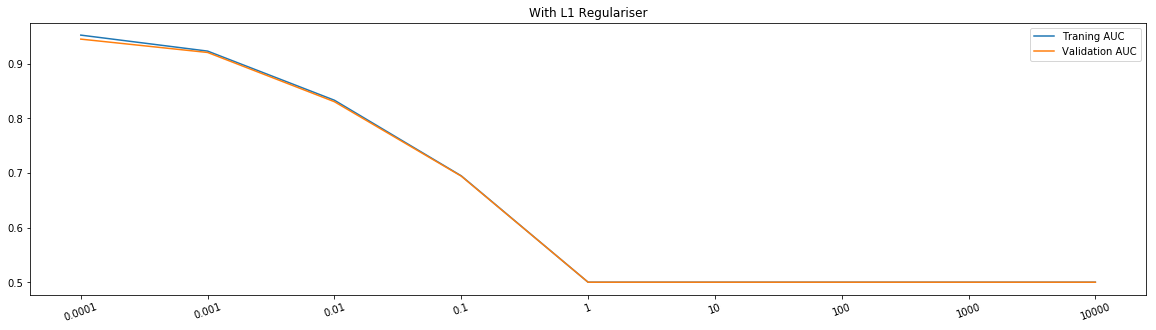

In [34]:
plt.figure(figsize=(20,5))
plt.plot(range(len(alpha)), auc_lsvm_bow_tr)
plt.plot(range(len(alpha)), auc_lsvm_bow_cv)
plt.xticks(range(len(alpha)), alpha, rotation = 20)
plt.title("With L1 Regulariser")
plt.legend(['Traning AUC', 'Validation AUC'])
plt.show()

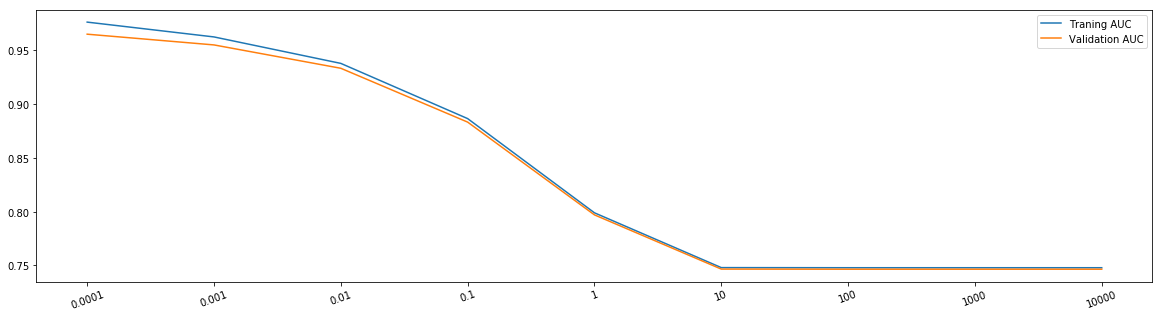

In [64]:
plt.figure(figsize=(20,5))
plt.plot(range(len(alpha)), auc_lsvm_bow_tr_l2)
plt.plot(range(len(alpha)), auc_lsvm_bow_cv_l2)
plt.xticks(range(len(alpha)), alpha, rotation = 20)
plt.legend(['Traning AUC', 'Validation AUC'])
#plt.title("With L2 Regulariser")
plt.show()

#### From graph alpha value 0.01 and L2 regularizer

In [333]:
X_train_bow_vec_full.shape

(145873, 59115)

In [40]:
from sklearn.metrics import roc_curve,roc_auc_score, auc

SGD_LSVM_Bow_opt = SGDClassifier(loss='hinge', penalty='l2', alpha=0.001)
#SGD_LSVM_Bow_opt.fit(X_train_bow_vec, Y_train_split)
CCV_BoW_opt = CalibratedClassifierCV(SGD_LSVM_Bow, cv=None, method='sigmoid')
CCV_BoW_opt.fit(X_train_bow_vec, Y_train_split)
Y_pred_prob_tr_bow = CCV_BoW_opt.predict_proba(X_train_bow_vec)[:,1]
Y_pred_prob_test_bow_lsvm = CCV_BoW_opt.predict_proba(X_test_bow_vec)[:,1]
Y_pred_tr_bow = CCV_BoW_opt.predict(X_train_bow_vec)
Y_pred_test_bow_lsvm = CCV_BoW_opt.predict(X_test_bow_vec)

#Y_pred_tr_Bow_lsvm = SGD_LSVM_Bow_opt.predict(X_train_bow_vec)
auc_pred_tr_lsvm = roc_auc_score(Y_train_split, Y_pred_prob_tr_bow)
auc_pred_test_lsvm = roc_auc_score(Y_test, Y_pred_prob_test_bow_lsvm)
fpr_tr, tpr_tr, _ = roc_curve(Y_train_split, Y_pred_prob_tr_bow)
fpr_ts, tpr_ts, _ = roc_curve(Y_test, Y_pred_prob_test_bow_lsvm)
auc_opt_lsvm_bow_tr = auc(fpr_tr, tpr_tr)
auc_opt_lsvm_bow_test = auc(fpr_ts, tpr_ts)
print("AUC Train: %0.3f AUC Test: %0.3f "%(auc_pred_tr_lsvm, auc_pred_test_lsvm))


AUC Train: 0.748 AUC Test: 0.747 


In [41]:
def plotROC(fpr, tpr, fpr_test, tpr_test, auc_tr, auc_test): 
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC on train data = %0.3f' % auc_tr)
    plt.plot(fpr_test, tpr_test, 'g', label = 'AUC on test data = %0.3f' % auc_test)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    #plt.xlim([0, 1])
    #plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

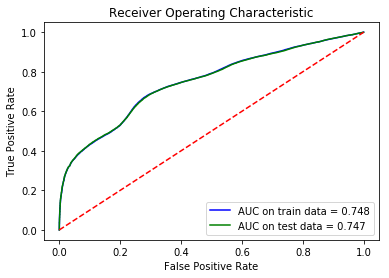

In [42]:
plotROC(fpr_tr, tpr_tr, fpr_ts, tpr_ts, auc_opt_lsvm_bow_tr, auc_opt_lsvm_bow_test)

In [44]:
#confusion matirx
import scikitplot.metrics as skplt

def plotConfusion(Y_tr,Y_prob_tr, Y_ts, Y_prob_ts):
    # for train data prediction
    skplt.plot_confusion_matrix(Y_tr, Y_prob_tr)
    #for test data prediction
    skplt.plot_confusion_matrix(Y_ts, Y_prob_ts)

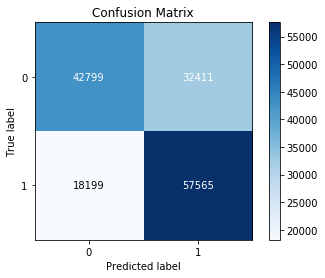

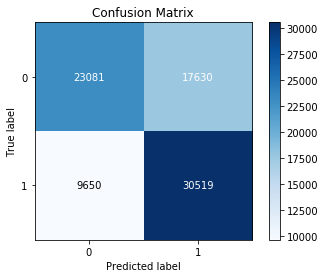

In [46]:
plotConfusion(Y_train_split, Y_pred_tr_bow,Y_test,Y_pred_test_bow_lsvm)

In [47]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

print("Precision of test: %0.4f"%(precision_score(Y_test, Y_pred_test_bow_lsvm)))
print("Recall of test: %0.4f"%(recall_score(Y_test, Y_pred_test_bow_lsvm)))
print("F1 Score of test: %0.4f"%(f1_score(Y_test, Y_pred_test_bow_lsvm)))

Precision of test: 0.6338
Recall of test: 0.7598
F1 Score of test: 0.6911


In [111]:
import pickle
filename = 'CCV_BoW_opt.sav'
pickle.dump(CCV_BoW_opt, open(filename, 'wb'))

### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [48]:
from sklearn.model_selection import train_test_split

X_train_tf, X_test_tf, Y_train_tf, Y_test_tf = train_test_split(preprocessed_reviews,df_upsampled['Score'].values,test_size=0.3,shuffle=True)
X_train_tf_split, X_CV_tf_split, Y_train_tf_split, Y_CV_tf_split = train_test_split(X_train_tf,Y_train_tf,test_size=0.2,shuffle=False)
#print(X_train_bow.shape)
print(len(X_train_tf), len(X_test_tf),len(X_train_tf_split), len(X_CV_tf_split), len(Y_train_tf), len(Y_test_tf), len(Y_train_tf_split), len(Y_CV_tf_split))

print(pd.DataFrame(Y_train_tf)[0].value_counts())
print(pd.DataFrame(Y_train_tf_split)[0].value_counts())
print(pd.DataFrame(Y_CV_tf_split)[0].value_counts())
print(pd.DataFrame(Y_test_tf)[0].value_counts())

188718 80880 150974 37744 188718 80880 150974 37744
1    94433
0    94285
Name: 0, dtype: int64
1    75649
0    75325
Name: 0, dtype: int64
0    18960
1    18784
Name: 0, dtype: int64
0    40514
1    40366
Name: 0, dtype: int64


In [49]:
print(X_train_tf[0],"****Length: ", len(X_train_tf[0]))

love chai perfect chilly fall evening purchased share family friends product delicious shipping super fast try not disappointed ****Length:  127


In [50]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train_tf_split)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

X_train_tf_vec = tf_idf_vect.transform(X_train_tf_split)
print("the type of count vectorizer ",type(X_train_tf_vec))
print("the shape of out text TFIDF vectorizer ",X_train_tf_vec.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_train_tf_vec.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abc', 'abdomen', 'abdominal', 'abdominal pain', 'aberration']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (150974, 101941)
the number of unique words including both unigrams and bigrams  101941


In [51]:
X_train_tf_vec_full = tf_idf_vect.transform(X_train_tf)
X_train_tf_vec[0]

<1x101941 sparse matrix of type '<class 'numpy.float64'>'
	with 26 stored elements in Compressed Sparse Row format>

In [52]:
X_CV_tf_vec = tf_idf_vect.transform(X_CV_tf_split)
X_test_tf_vec = tf_idf_vect.transform(X_test_tf)

In [53]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
auc_lsvm_tf_tr = []
auc_lsvm_tf_cv = []
auc_lsvm_tf_test = []
XLabels = []
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
penalty = ["l1", "l2"]
auc_lsvm_tf_tr_l2 = []
auc_lsvm_tf_cv_l2 = []

for alp in tqdm(alpha):
    for pen in penalty:
        temp = str(alp)+"/"+pen
        XLabels.append(temp)
        #SGD Classifier with hinge loss and varying penalty and alpha value
        SGD_LSVM_tf = SGDClassifier(loss='hinge', penalty=pen, alpha=alp)
        #Fit the model on train(split) data
        CCV_tf = CalibratedClassifierCV(SGD_LSVM_tf, cv=None, method='sigmoid')
        CCV_tf.fit(X_train_tf_vec, Y_train_tf_split)
        #Predict the target value for train data
        Y_pred_LSVM_tf_tr = (CCV_tf.predict_proba(X_train_tf_vec))[:,1]
        #Get AUC Value for train data
        #auc_lsvm_tf_tr.append(roc_auc_score(Y_train_tf_split, Y_pred_LSVM_tf_tr))
        #Predict the target value for CV data
        Y_pred_LSVM_tf_cv = (CCV_tf.predict_proba(X_CV_tf_vec))[:,1]
        #Get AUC Value
        if pen == "l1":
            auc_lsvm_tf_tr.append(roc_auc_score(Y_train_tf_split, Y_pred_LSVM_tf_tr))
            auc_lsvm_tf_cv.append(roc_auc_score(Y_CV_tf_split, Y_pred_LSVM_tf_cv))
        else:
            auc_lsvm_tf_tr_l2.append(roc_auc_score(Y_train_tf_split, Y_pred_LSVM_tf_tr))
            auc_lsvm_tf_cv_l2.append(roc_auc_score(Y_CV_tf_split, Y_pred_LSVM_tf_cv))
        
        #auc_lsvm_tf_cv.append(roc_auc_score(Y_CV_tf_split, Y_pred_LSVM_tf_cv))

100%|████████████████████████████████████████████| 9/9 [00:46<00:00,  5.15s/it]


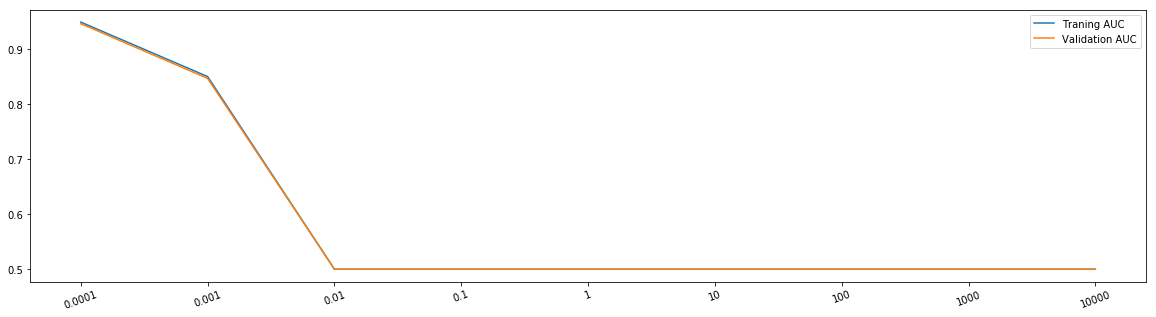

In [54]:
plt.figure(figsize=(20,5))
plt.plot(range(len(alpha)), auc_lsvm_tf_tr)
plt.plot(range(len(alpha)), auc_lsvm_tf_cv)
plt.xticks(range(len(alpha)), alpha, rotation = 20)
plt.legend(['Traning AUC', 'Validation AUC'])
plt.show()

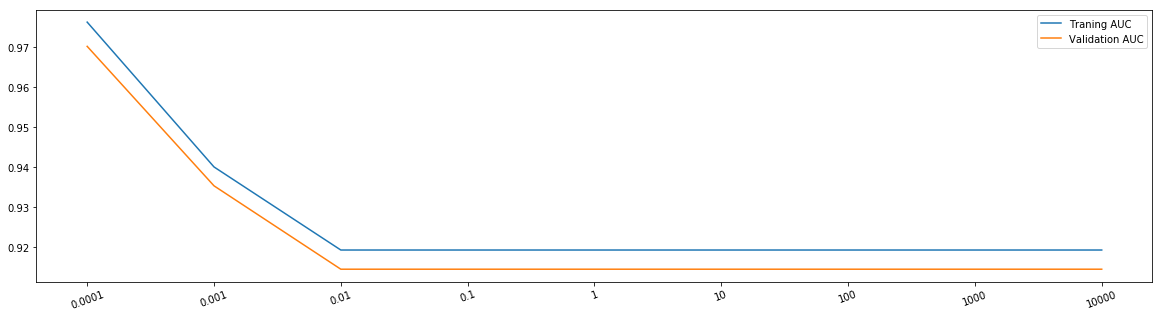

In [55]:
plt.figure(figsize=(20,5))
plt.plot(range(len(alpha)), auc_lsvm_tf_tr_l2)
plt.plot(range(len(alpha)), auc_lsvm_tf_cv_l2)
plt.xticks(range(len(alpha)), alpha, rotation = 20)
plt.legend(['Traning AUC', 'Validation AUC'])
plt.show()

#### From graph, Alpha = 0.0001 and L2 regularizer

In [103]:
SGD_LSVM_tf_opt = SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001)
CCV_tf_opt = CalibratedClassifierCV(SGD_LSVM_tf, cv=None, method='sigmoid')
CCV_tf_opt.fit(X_train_tf_vec, Y_train_tf_split)
Y_pred_prob_tr_tf_lsvm = CCV_tf_opt.predict_proba(X_train_tf_vec_full)[:,1]
Y_pred_tr_tf_lsvm = CCV_tf_opt.predict(X_train_tf_vec_full)
auc_pred_tr_lsvm = roc_auc_score(Y_train_tf, Y_pred_prob_tr_tf_lsvm)
Y_pred_prob_test_tf_lsvm = CCV_tf_opt.predict_proba(X_test_tf_vec)[:,1]
Y_pred_test_tf_lsvm = CCV_tf_opt.predict(X_test_tf_vec)
auc_pred_test_lsvm = roc_auc_score(Y_test_tf, Y_pred_prob_test_tf_lsvm)
print("AUC value of train data: ",auc_pred_tr_lsvm)
print("AUC value of test data: ", auc_pred_test_lsvm)

AUC value of train data:  0.9188949057746835
AUC value of test data:  0.9167011620321861


In [35]:
def plotROC(Y_Target_tr, Y_pred_tr, Y_target_ts, Y_pred_ts): 
    fpr, tpr, _ = roc_curve(Y_Target_tr, Y_pred_tr)
    auc_tr = auc(fpr, tpr)
    fpr_test, tpr_test, _ = roc_curve(Y_target_ts, Y_pred_ts)
    auc_test = auc(fpr_test, tpr_test)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC on train data = %0.3f' % auc_tr)
    plt.plot(fpr_test, tpr_test, 'g', label = 'AUC on test data = %0.3f' % auc_test)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

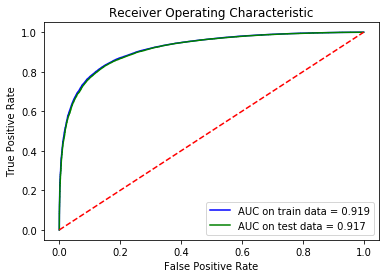

In [107]:
plotROC(Y_train_tf, Y_pred_prob_tr_tf_lsvm,Y_test_tf, Y_pred_prob_test_tf_lsvm)

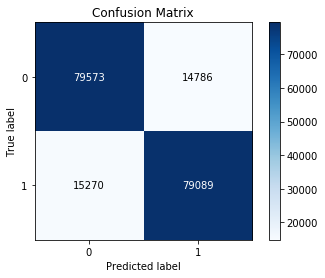

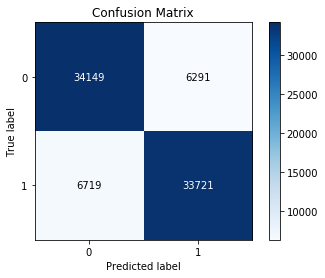

In [108]:
plotConfusion(Y_train_tf, Y_pred_tr_tf_lsvm,Y_test_tf,Y_pred_test_tf_lsvm)

In [109]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

print("Precision of test: %0.4f"%(precision_score(Y_test_tf, Y_pred_test_tf_lsvm)))
print("Recall of test: %0.4f"%(recall_score(Y_test_tf, Y_pred_test_tf_lsvm)))
print("F1 Score of test: %0.4f"%(f1_score(Y_test_tf, Y_pred_test_tf_lsvm)))

Precision of test: 0.8428
Recall of test: 0.8339
F1 Score of test: 0.8383


In [143]:
import pickle
filename = 'CCV_tf_opt.sav'
pickle.dump(CCV_tf_opt, open(filename, 'wb'))

## Word2Vec

In [133]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in X_train_split:
    list_of_sentance.append(sentance.split())

In [135]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(X_train_split,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8513876795768738), ('fantastic', 0.8472415208816528), ('good', 0.8463031649589539), ('terrific', 0.8382092118263245), ('excellent', 0.8160351514816284), ('wonderful', 0.7928973436355591), ('perfect', 0.7627450823783875), ('amazing', 0.7158016562461853), ('incredible', 0.7055635452270508), ('nice', 0.6980966329574585)]
[('greatest', 0.7917865514755249), ('best', 0.7097898721694946), ('tastiest', 0.6881978511810303), ('nastiest', 0.6820705533027649), ('displeasure', 0.6654118299484253), ('worse', 0.6531224846839905), ('disgusting', 0.6300880312919617), ('sweetest', 0.6035254597663879), ('horrible', 0.5979403257369995), ('awful', 0.5931264162063599)]


In [136]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  17851
sample words  ['remembered', 'book', 'childhood', 'got', 'kids', 'good', 'love', 'older', 'daughter', 'reads', 'sister', 'rhymes', 'nice', 'pictures', 'loves', 'really', 'books', 'introduced', 'cd', 'performed', 'king', 'also', 'available', 'amazon', 'birthday', 'year', 'later', 'knows', 'songs', 'far', 'go', 'one', 'johnny', 'around', 'chicken', 'soup', 'w', 'rice', 'well', 'written', 'clever', 'art', 'work', 'maurice', 'sendak', 'plus', 'cheap', 'highly', 'recommended', 'best']


### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [56]:
train_sent_vectors = np.load("sent_vectors_train_aw.npy")
test_sent_vectors = np.load("sent_vectors_test_aw.npy")
CV_sent_vectors = np.load("sent_vectors_CV_aw.npy")
Y_train_aw_split = np.load("Y_train_split_aw.npy")
Y_test_aw = np.load("Y_test_aw.npy")
Y_CV_aw_split = np.load("Y_CV_aw.npy")

In [58]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
auc_lsvm_aw_tr = []
auc_lsvm_aw_cv = []
XLabels = []
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
penalty = ["l1", "l2"]
auc_lsvm_aw_tr_l2 = []
auc_lsvm_aw_cv_l2 = []

for alp in tqdm(alpha):
    for pen in penalty:
        temp = str(alp)+"/"+pen
        XLabels.append(temp)
        #SGD Classifier with hinge loss and varying penalty and alpha value
        SGD_LSVM_aw = SGDClassifier(loss='hinge', penalty=pen, alpha=alp)
        #Fit the model on train(split) data
        CCV_aw = CalibratedClassifierCV(SGD_LSVM_tf, cv=3, method='sigmoid')
        CCV_aw.fit(train_sent_vectors, Y_train_aw_split)
        #Predict the target value for train data
        Y_pred_LSVM_aw_tr = CCV_aw.predict_proba(train_sent_vectors)[:,1]
        #Get AUC Value for train data
        #auc_lsvm_aw_tr.append(roc_auc_score(Y_train_aw_split, Y_pred_LSVM_aw_tr))
        #Predict the target value for CV data
        Y_pred_LSVM_aw_cv = CCV_aw.predict_proba(CV_sent_vectors)[:,1]
        #Get AUC Value
        #auc_lsvm_aw_cv.append(roc_auc_score(Y_CV_aw_split, Y_pred_LSVM_aw_cv))
        
        if pen == "l1":
            auc_lsvm_aw_tr.append(roc_auc_score(Y_train_aw_split, Y_pred_LSVM_aw_tr))
            auc_lsvm_aw_cv.append(roc_auc_score(Y_CV_aw_split, Y_pred_LSVM_aw_cv))
        else:
            auc_lsvm_aw_tr_l2.append(roc_auc_score(Y_train_aw_split, Y_pred_LSVM_aw_tr))
            auc_lsvm_aw_cv_l2.append(roc_auc_score(Y_CV_aw_split, Y_pred_LSVM_aw_cv))

100%|████████████████████████████████████████████| 9/9 [00:10<00:00,  1.11s/it]


In [130]:
train_sent_vectors[:1,:]

array([[ 0.01165107, -0.60764464, -0.07707862, -0.37808888, -0.29754238,
        -0.09156758, -0.36461395, -0.71511264, -0.46395879, -0.55941492,
         0.46100987, -0.13578257,  0.06663931,  0.15255156, -0.05656241,
        -0.18916887, -0.58221793,  0.12107546,  0.24535833, -0.0742102 ,
         0.16984009,  0.16698894, -0.1324623 ,  0.30965401,  0.33240298,
        -0.9903243 ,  0.39126083, -0.08637016, -0.30787156,  0.25303264,
        -0.47216592,  0.66212215, -0.57740729, -0.43864164,  0.14998249,
         0.1154069 ,  0.09567072,  0.12240899, -0.77381682, -0.06313179,
         0.8608704 ,  0.56563987, -0.00670631,  0.25190731, -0.25691899,
         0.70003837, -0.33667303,  0.30829011, -0.45164093,  0.08974965]])

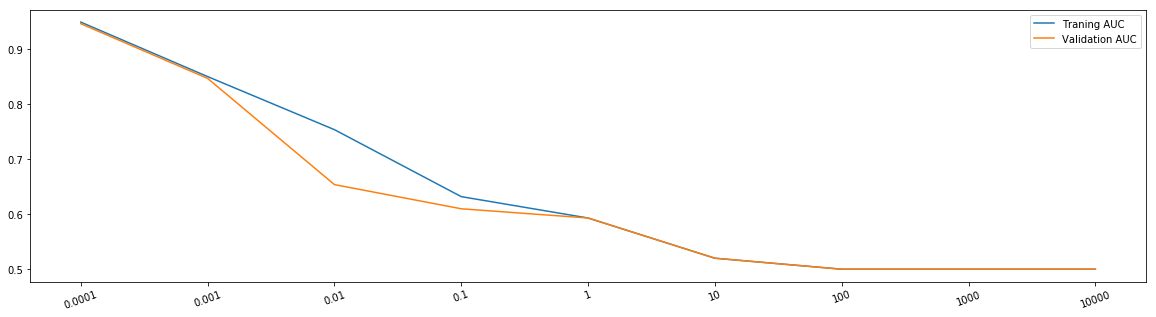

In [71]:
plt.figure(figsize=(20,5))
plt.plot(range(len(alpha)), auc_lsvm_aw_tr)
plt.plot(range(len(alpha)), auc_lsvm_aw_cv)
plt.xticks(range(len(alpha)), alpha, rotation = 20)
plt.legend(['Traning AUC', 'Validation AUC'])
plt.show()

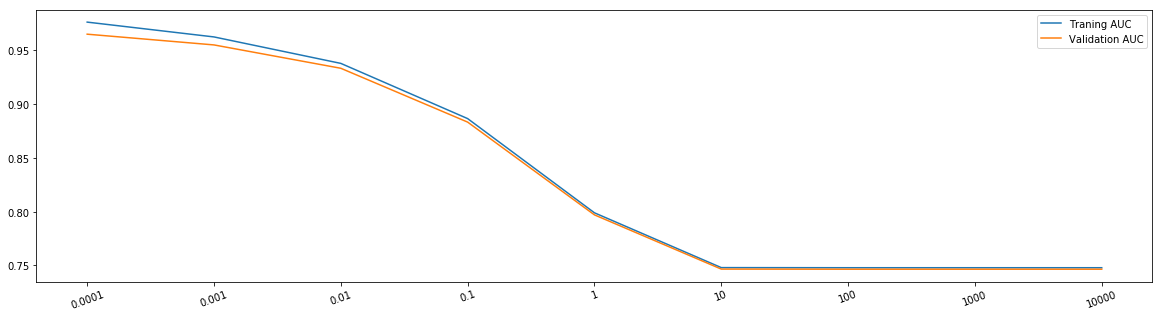

In [64]:
plt.figure(figsize=(20,5))
plt.plot(range(len(alpha)), auc_lsvm_aw_tr_l2)
plt.plot(range(len(alpha)), auc_lsvm_aw_cv_l2)
plt.xticks(range(len(alpha)), alpha, rotation = 20)
plt.legend(['Traning AUC', 'Validation AUC'])
plt.show()

#### From graph, Alpha = 0.001 and L2 regularizer

In [139]:
SGD_LSVM_aw_opt = SGDClassifier(loss='hinge', penalty='l2', alpha=0.001)
CCV_aw_opt = CalibratedClassifierCV(SGD_LSVM_tf, cv=3, method='sigmoid')
CCV_aw_opt.fit(train_sent_vectors, Y_train_aw_split)
Y_pred_prob_tr_aw_lsvm = CCV_aw_opt.predict_proba(train_sent_vectors)[:,1]
Y_pred_tr_aw_lsvm = CCV_aw_opt.predict(train_sent_vectors)

auc_pred_tr_lsvm = roc_auc_score(Y_train_aw_split, Y_pred_prob_tr_aw_lsvm)
Y_pred_prob_test_aw_lsvm = CCV_aw_opt.predict_proba(test_sent_vectors)[:,1]
Y_pred_test_aw_lsvm = CCV_aw_opt.predict(test_sent_vectors)

auc_pred_test_lsvm = roc_auc_score(Y_test_aw, Y_pred_prob_test_aw_lsvm)
print("AUC value of train data: ",auc_pred_tr_lsvm)
print("AUC value of test data: ", auc_pred_test_lsvm)

AUC value of train data:  0.7828848950934086
AUC value of test data:  0.7849940064537859


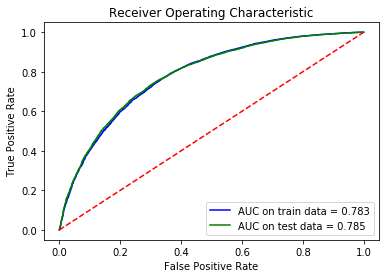

In [136]:
plotROC(Y_train_aw_split, Y_pred_tr_aw_lsvm, Y_test_aw, Y_pred_test_aw_lsvm)

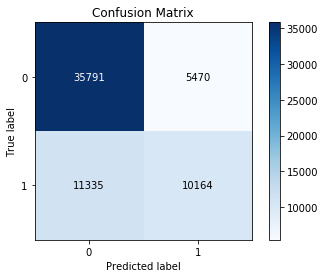

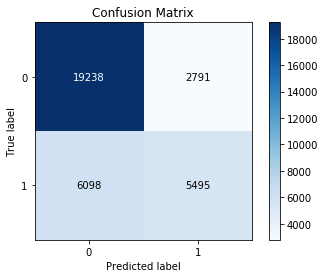

In [141]:
plotConfusion(Y_train_aw_split, Y_pred_tr_aw_lsvm,Y_test_aw,Y_pred_test_aw_lsvm)

In [144]:
import pickle
filename = 'CCV_aw_opt.sav'
pickle.dump(CCV_aw_opt, open(filename, 'wb'))

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [61]:
train_tfidf_sent_vectors = np.load("tfidf_sent_vectors_tw_train.npy")
CV_tfidf_sent_vectors = np.load("tfidf_sent_vectors_tw_CV.npy")
test_tfidf_sent_vectors = np.load("tfidf_sent_vectors_tw_test.npy")
Y_train_tw_split_part = np.load("Y_train_split_tw.npy")
Y_CV_tw_split = np.load("Y_CV_tw.npy")
Y_test_tw_split_part = np.load("Y_test_tw.npy")

In [62]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
auc_lsvm_tw_tr = []
auc_lsvm_tw_cv = []
XLabels = []
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
penalty = ["l1", "l2"]
auc_lsvm_tw_tr_l2 = []
auc_lsvm_tw_cv_l2 = []

for alp in tqdm(alpha):
    for pen in penalty:
        temp = str(alp)+"/"+pen
        XLabels.append(temp)
        #SGD Classifier with hinge loss and varying penalty and alpha value
        SGD_LSVM_tw = SGDClassifier(loss='hinge', penalty=pen, alpha=alp)
        CCV_tw = CalibratedClassifierCV(SGD_LSVM_tf, cv=3, method='sigmoid')
        CCV_tw.fit(train_tfidf_sent_vectors, Y_train_tw_split_part)
        #Predict the target value for train data
        Y_pred_LSVM_tw_tr = (CCV_tw.predict_proba(train_tfidf_sent_vectors))[:,1]
        #Get AUC Value for train data
        #auc_lsvm_tw_tr.append(roc_auc_score(Y_train_tw_split_part, Y_pred_LSVM_tw_tr))
        #Predict the target value for CV data
        Y_pred_LSVM_tw_cv = (CCV_tw.predict_proba(CV_tfidf_sent_vectors))[:,1]
        #Get AUC Value
        #auc_lsvm_tw_cv.append(roc_auc_score(Y_CV_tw_split, Y_pred_LSVM_tw_cv))
        
        if pen == "l1":
            auc_lsvm_tw_tr.append(roc_auc_score(Y_train_tw_split_part, Y_pred_LSVM_tw_tr))
            auc_lsvm_tw_cv.append(roc_auc_score(Y_CV_tw_split, Y_pred_LSVM_tw_cv))
        else:
            auc_lsvm_tw_tr_l2.append(roc_auc_score(Y_train_tw_split_part, Y_pred_LSVM_tw_tr))
            auc_lsvm_tw_cv_l2.append(roc_auc_score(Y_CV_tw_split, Y_pred_LSVM_tw_cv))

100%|████████████████████████████████████████████| 9/9 [00:09<00:00,  1.07s/it]


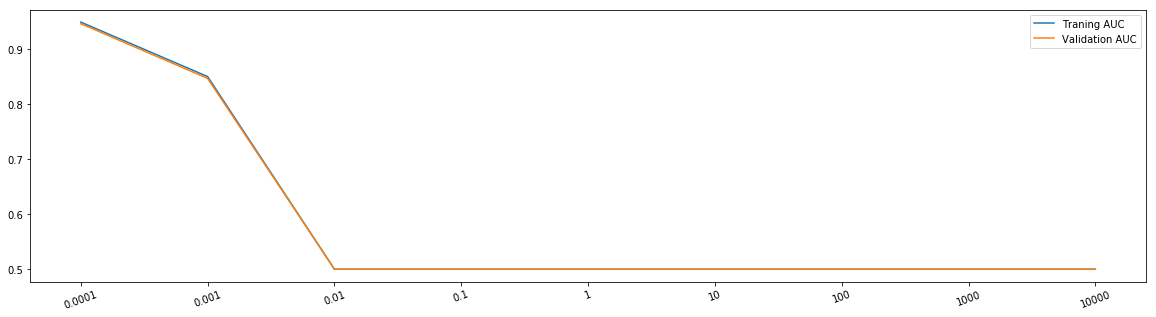

In [54]:
plt.figure(figsize=(20,5))
plt.plot(range(len(alpha)), auc_lsvm_tw_tr)
plt.plot(range(len(alpha)), auc_lsvm_tw_cv)
plt.xticks(range(len(alpha)), alpha, rotation = 20)
plt.legend(['Traning AUC', 'Validation AUC'])
plt.show()

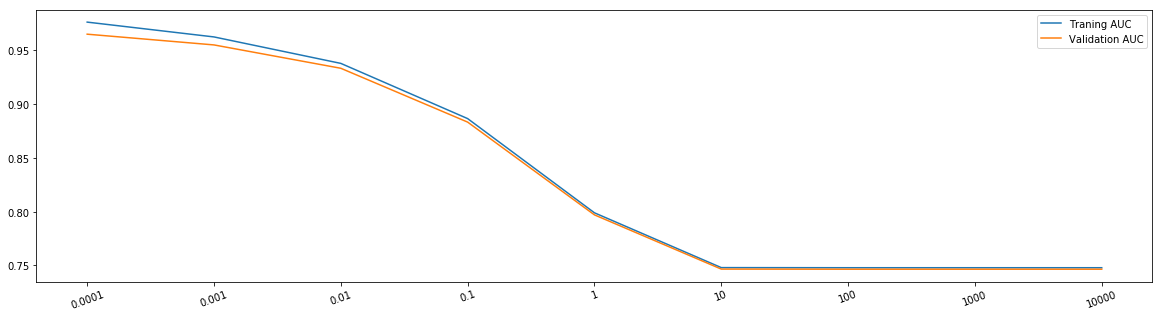

In [64]:
plt.figure(figsize=(20,5))
plt.plot(range(len(alpha)), auc_lsvm_tw_tr_l2)
plt.plot(range(len(alpha)), auc_lsvm_tw_cv_l2)
plt.xticks(range(len(alpha)), alpha, rotation = 20)
plt.legend(['Traning AUC', 'Validation AUC'])
plt.show()

In [148]:
SGD_LSVM_tw_opt = SGDClassifier(loss='hinge', penalty='l1', alpha=0.001)
CCV_tw = CalibratedClassifierCV(SGD_LSVM_tf, cv=3, method='sigmoid')
CCV_tw.fit(train_tfidf_sent_vectors, Y_train_tw_split_part)

SGD_LSVM_tw_opt.fit(train_tfidf_sent_vectors, Y_train_tw_split_part)
Y_pred_tr_tw_lsvm = SGD_LSVM_tw_opt.predict(train_tfidf_sent_vectors)
auc_pred_tr_lsvm = roc_auc_score(Y_train_tw_split_part, Y_pred_tr_tw_lsvm)
Y_pred_test_tw_lsvm = SGD_LSVM_tw_opt.predict(test_tfidf_sent_vectors)
auc_pred_test_lsvm = roc_auc_score(Y_test_tw_split_part, Y_pred_test_tw_lsvm)
print("AUC value of train data: ",auc_pred_tr_lsvm)
print("AUC value of test data: ", auc_pred_test_lsvm)

AUC value of train data:  0.7688814658082964
AUC value of test data:  0.7689114484097391


In [149]:
fpr, tpr, _ = roc_curve(Y_train_tw_split_part, Y_pred_tr_tw_lsvm)
fpr_test, tpr_test, _ = roc_curve(Y_test_tw_split_part, Y_pred_test_tw_lsvm)
auc_opt_lsvm_tw_tr = auc(fpr, tpr)
auc_opt_lsvm_tw_test = auc(fpr_test, tpr_test)
print(auc_opt_lsvm_tw_tr, auc_opt_lsvm_tw_test)

0.7688814658082964 0.7689114484097391


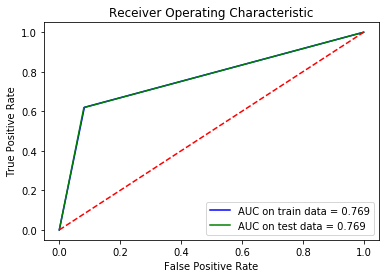

In [151]:
plotROC(Y_train_tw_split_part, Y_pred_tr_tw_lsvm, Y_test_tw_split_part, Y_pred_test_tw_lsvm, )

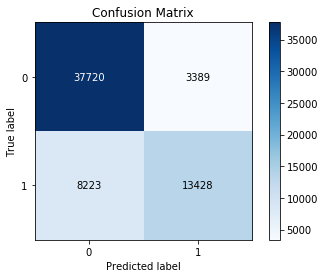

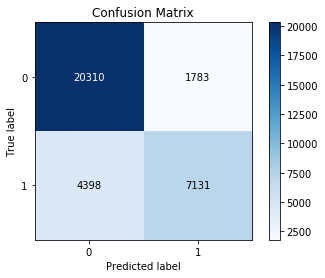

In [152]:
plotConfusion(Y_train_tw_split_part, Y_pred_tr_tw_lsvm,Y_test_tw_split_part,Y_pred_test_tw_lsvm)

In [153]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

print("Precision of test: %0.4f"%(precision_score(Y_test_tw_split_part, Y_pred_test_tw_lsvm)))
print("Recall of test: %0.4f"%(recall_score(Y_test_tw_split_part, Y_pred_test_tw_lsvm)))
print("F1 Score of test: %0.4f"%(f1_score(Y_test_tw_split_part, Y_pred_test_tw_lsvm)))

Precision of test: 0.8000
Recall of test: 0.6185
F1 Score of test: 0.6976


In [ ]:
import pickle
filename = 'CCV_aw_opt.sav'
pickle.dump(CCV_aw_opt, open(filename, 'wb'))

## [5.2] RBF SVM

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mi>K</mi>
  <mo stretchy="false">(</mo>
  <mrow class="MJX-TeXAtom-ORD">
    <mi mathvariant="bold">x</mi>
  </mrow>
  <mo>,</mo>
  <mrow class="MJX-TeXAtom-ORD">
    <msup>
      <mi mathvariant="bold">x</mi>
      <mo>&#x2032;</mo>
    </msup>
  </mrow>
  <mo stretchy="false">)</mo>
  <mo>=</mo>
  <mi>exp</mi>
  <mo>&#x2061;<!-- ⁡ --></mo>
  <mrow>
    <mo>(</mo>
    <mrow>
      <mo>&#x2212;<!-- − --></mo>
      <mrow class="MJX-TeXAtom-ORD">
        <mfrac>
          <mrow>
            <mrow class="MJX-TeXAtom-ORD">
              <mo stretchy="false">|</mo>
            </mrow>
            <mrow class="MJX-TeXAtom-ORD">
              <mo stretchy="false">|</mo>
            </mrow>
            <mrow class="MJX-TeXAtom-ORD">
              <mi mathvariant="bold">x</mi>
            </mrow>
            <mo>&#x2212;<!-- − --></mo>
            <mrow class="MJX-TeXAtom-ORD">
              <msup>
                <mi mathvariant="bold">x</mi>
                <mo>&#x2032;</mo>
              </msup>
            </mrow>
            <mrow class="MJX-TeXAtom-ORD">
              <mo stretchy="false">|</mo>
            </mrow>
            <msup>
              <mrow class="MJX-TeXAtom-ORD">
                <mo stretchy="false">|</mo>
              </mrow>
              <mrow class="MJX-TeXAtom-ORD">
                <mn>2</mn>
              </mrow>
            </msup>
          </mrow>
          <mrow>
            <mn>2</mn>
            <msup>
              <mi>&#x03C3;<!-- σ --></mi>
              <mrow class="MJX-TeXAtom-ORD">
                <mn>2</mn>
              </mrow>
            </msup>
          </mrow>
        </mfrac>
      </mrow>
    </mrow>
    <mo>)</mo>
  </mrow>
</math>

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [301]:
from sklearn.model_selection import train_test_split

X_train_bow, X_test_bow, Y_train_bow, Y_test_bow = train_test_split(preprocessed_reviews, df_upsampled['Score'].values,test_size=0.3,shuffle=True)
X_train_bow_split, X_CV_bow_split, Y_train_bow_split, Y_CV_bow_split = train_test_split(X_train_bow, Y_train_bow,test_size=0.2,shuffle=False)
print(len(X_train_bow), len(Y_train_bow), len(X_train_bow_split), len(Y_train_bow_split), len(X_test_bow), len(Y_test_bow),len(X_CV_bow_split), len(Y_CV_bow_split))

145873 145873 116698 116698 62518 62518 29175 29175


In [302]:
#BoW
count_vect = CountVectorizer(max_features=500, min_df=10) #in scikit-learn
count_vect.fit(X_train_bow_split)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

X_train_bow_vec = count_vect.transform(X_train_bow_split)
print("the type of count vectorizer ",type(X_train_bow_vec))
print("the shape of out text BOW vectorizer ",X_train_bow_vec.get_shape())
print("the number of unique words ", X_train_bow_vec.get_shape()[1])

some feature names  ['able', 'absolutely', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almost', 'also', 'alternative']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (116698, 500)
the number of unique words  500


In [303]:
X_train_bow_vec_full = count_vect.transform(X_train_bow)
X_CV_bow_split_vec = count_vect.transform(X_CV_bow_split)
X_train_bow_split_vec = count_vect.transform(X_train_bow_split)
X_test_bow_vec = count_vect.transform(X_test_bow)

In [305]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate until the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score,roc_curve, auc
auc_RBFSVM_tr = []
auc_RBFSVM_cv = []
XLabels = []
C_Set = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
Gamma = [0.001, 0.01, 0.1, 1, 10, 100]


for C in tqdm(C_Set):
    for Gam in Gamma:
        temp = "G="+str(Gam)+"/ C="+str(C)
        XLabels.append(temp)
        #SVM - using SVC
        SVM_Bow = SVC(kernel='rbf', random_state=0, gamma=Gam, C=C, probability=True)
        #Fit the model on train(split) data
        SVM_Bow.fit(X_test_bow_vec, Y_test_bow)
        #Predict the target value for train data
        Y_pred_RBFSVM_tr = (batch_predict(SVM_Bow, X_test_bow_vec))
        #Get AUC Value for train data
        fpr_tr, tpr_tr, _ = roc_score(Y_test_bow, Y_pred_RBFSVM_tr)
        temp_AUC_tr = auc(fpr_tr, tpr_tr)
        auc_RBFSVM_tr.append(temp_AUC_tr)
        #Predict the target value for CV data
        Y_pred_RBFSVM_cv = (batch_predict(SVM_Bow, X_CV_bow_split_vec))
        #Get AUC Value
        fpr_cv, tpr_cv, _ = roc_score(Y_CV_bow_split, Y_pred_RBFSVM_cv)
        temp_AUC_cv = auc(fpr_cv, tpr_cv)
        auc_RBFSVM_cv.append(temp_AUC_cv)
        print("For Gamma= ",Gam,"and C=",C," AUC of train data= ", temp_AUC_tr, " AUC of CV data= ", temp_AUC_cv)

### For Gamma=  0.01 and C= 1  AUC of train data=  0.939514493061344  AUC of CV data=  0.9037320666033548

In [ ]:
SVC_RBFSVM_Bow = SVC(kernel='rbf', random_state=0, gamma=0.01, C=1, probability=True)
SVC_RBFSVM_Bow.fit(X_train_bow_split_vec, Y_train_bow_split)

In [144]:
Y_pred_tr_Bow_RBFsvm = SVC_RBFSVM_Bow.predict_proba(X_train_bow_split_vec)
auc_pred_tr_RBFsvm = roc_auc_score(Y_train_bow_split, Y_pred_tr_Bow_RBFsvm)
Y_pred_test_bow_RBFsvm = SVC_RBFSVM_Bow.predict_proba(X_test_bow_vec)
auc_pred_test_RBFsvm = roc_auc_score(Y_test_bow, Y_pred_test_bow_RBFsvm)
print("AUC value of train data: ",auc_pred_tr_RBFsvm)
print("AUC value of test data: ", auc_pred_test_RBFsvm)

AUC value of train data:  0.7386481311698427
AUC value of test data:  0.7098874021619426


In [147]:
def plotROC(fpr, tpr, fpr_test, tpr_test, auc_tr, auc_test): 
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC on train data = %0.3f' % auc_tr)
    plt.plot(fpr_test, tpr_test, 'g', label = 'AUC on test data = %0.3f' % auc_test)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    #plt.xlim([0, 1])
    #plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

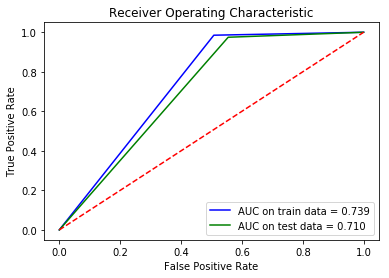

In [148]:
plotROC(fpr, tpr, fpr_test, tpr_test, auc_opt_RBFsvm_bow_tr, auc_opt_RBFlsvm_bow_test)

In [38]:
#confusion matirx
import scikitplot.metrics as skplt

def plotConfusion(Y_tr,Y_prob_tr, Y_ts, Y_prob_ts):
    # for train data prediction
    skplt.plot_confusion_matrix(Y_tr, Y_prob_tr)
    #for test data prediction
    skplt.plot_confusion_matrix(Y_ts, Y_prob_ts)

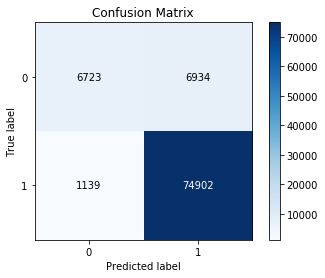

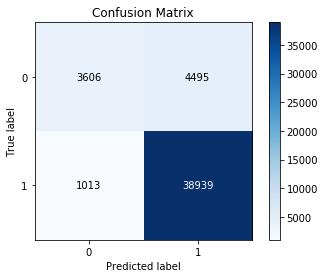

In [150]:
plotConfusion(Y_train_bow_split, Y_pred_tr_Bow_RBFsvm,Y_test_bow,Y_pred_test_bow_RBFsvm)

In [151]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

print("Precision of test: %0.4f"%(precision_score(Y_test_bow, Y_pred_test_bow_RBFsvm)))
print("Recall of test: %0.4f"%(recall_score(Y_test_bow, Y_pred_test_bow_RBFsvm)))
print("F1 Score of test: %0.4f"%(f1_score(Y_test_bow, Y_pred_test_bow_RBFsvm)))

Precision of test: 0.8965
Recall of test: 0.9746
F1 Score of test: 0.9339


In [158]:
import pickle
filename = 'SVC_RBFSVM_Bow.sav'
pickle.dump(SVC_RBFSVM_Bow, open(filename, 'wb'))

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [3]:
# Please write all the code with proper documentation

In [117]:
from sklearn.model_selection import train_test_split

X_train_tf, X_test_tf, Y_train_tf, Y_test_tf = train_test_split(preprocessed_reviews, final['Score'].values,test_size=0.3,shuffle=False)
X_train_tf_split, X_CV_tf_split, Y_train_tf_split, Y_CV_tf_split = train_test_split(X_train_tf, Y_train_tf,test_size=0.2,shuffle=False)
print(len(X_train_tf), len(Y_train_tf), len(X_train_tf_split), len(Y_train_tf_split), len(X_test_tf), len(Y_test_tf),len(X_CV_tf_split), len(Y_CV_tf_split))

112123 112123 89698 89698 48053 48053 22425 22425


In [189]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
tf_idf_vect.fit(X_train_tf_split)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

X_train_tf_vec = tf_idf_vect.transform(X_train_tf_split)
X_test_tf_vec = tf_idf_vect.transform(X_test_tf)
X_CV_tf_vec = tf_idf_vect.transform(X_CV_tf_split)
print("the type of count vectorizer ",type(X_train_tf_vec))
print("the shape of out text TFIDF vectorizer - Train: ",X_train_tf_vec.get_shape())
print("the shape of out text TFIDF vectorizer - Test: ",X_test_tf_vec.get_shape())
print("the shape of out text TFIDF vectorizer - CV: ",X_CV_tf_vec.get_shape())

print("the number of unique words including both unigrams and bigrams ", X_train_tf_vec.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'absolutely', 'actually', 'add', 'added', 'ago', 'almonds', 'almost', 'also', 'alternative']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer - Train:  (49152, 500)
the shape of out text TFIDF vectorizer - Test:  (26332, 500)
the shape of out text TFIDF vectorizer - CV:  (12289, 500)
the number of unique words including both unigrams and bigrams  500


In [194]:
print(X_train_tf_split[0])
print("X_train[0]:",X_train_tf_vec[0])
print(X_CV_tf_split[0])
print("X_CV[0]:", X_CV_tf_vec[0])

dogs loves chicken product china wont buying anymore hard find chicken products made usa one isnt bad good product wont take chances till know going china imports
X_train[0]:   (0, 430)	0.24845663393150147
  (0, 350)	0.23845488551157812
  (0, 349)	0.31417294828824244
  (0, 308)	0.1499380620040606
  (0, 259)	0.20994647375185366
  (0, 257)	0.2230340769855683
  (0, 232)	0.2203595508654001
  (0, 208)	0.23594322674035784
  (0, 197)	0.1373003109809547
  (0, 196)	0.2517710018060786
  (0, 165)	0.18400858906186915
  (0, 124)	0.24421602133706313
  (0, 77)	0.5184716200148916
  (0, 57)	0.23942835728530584
  (0, 28)	0.24554805601384522
light not super filling great meals snack lunch
X_CV[0]:   (0, 424)	0.5911186902687207
  (0, 402)	0.4742496374402724
  (0, 293)	0.19265814398788772
  (0, 241)	0.5546992488563749
  (0, 199)	0.28435463470124495


In [195]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate until the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
auc_RBFSVM_tr = []
auc_RBFSVM_cv = []
XLabels = []
C_Set = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
Gamma = [0.001, 0.01, 0.1, 1, 10, 100]


for C in tqdm(C_Set):
    for Gam in Gamma:
        temp = "G="+str(Gam)+"/ C="+str(C)
        XLabels.append(temp)
        #SVM - using SVC
        SVM_tf = SVC(kernel='rbf', random_state=0, gamma=Gam, C=C, probability=True)
        #Fit the model on train(split) data
        SVM_tf.fit(X_train_tf_vec, Y_train_tf_split)
        #Predict the target value for train data
        Y_pred_RBFSVM_tr = (batch_predict(SVM_tf, X_train_tf_vec))
        #Get AUC Value for train data
        temp_AUC_tr = roc_auc_score(Y_train_tf_split, Y_pred_RBFSVM_tr)
        auc_RBFSVM_tr.append(temp_AUC_tr)
        #Predict the target value for CV data
        Y_pred_RBFSVM_cv = (batch_predict(SVM_tf, X_CV_tf_vec))
        #Get AUC Value
        temp_AUC_cv = roc_auc_score(Y_CV_tf_split, Y_pred_RBFSVM_cv)
        auc_RBFSVM_cv.append(temp_AUC_cv)
        print("For Gamma= ",Gam,"and C=",C," AUC of train data= ", temp_AUC_tr, " AUC of CV data= ", temp_AUC_cv)

### For Gamma=  0.01 and C= 1  AUC of train data=  0.939514493061344  AUC of CV data=  0.9037320666033548

In [ ]:
SVC_RBFSVM_tf = SVC(kernel='rbf', random_state=0, gamma=0.01, C=1, probability=True)
SVC_RBFSVM_tf.fit(X_train_tf_full_vec, Y_train_tf)

In [144]:
Y_pred_tr_tf_RBFsvm = SVC_RBFSVM_tf.predict(X_train_tf_full_vec)
auc_pred_tr_RBFsvm = roc_auc_score(Y_train_tf, Y_pred_tr_tf_RBFsvm)
Y_pred_test_tf_RBFsvm = SVC_RBFSVM_tf.predict(X_test_tf_vec)
auc_pred_test_RBFsvm = roc_auc_score(Y_test_tf, Y_pred_test_tf_RBFsvm)
print("AUC value of train data: ",auc_pred_tr_RBFsvm)
print("AUC value of test data: ", auc_pred_test_RBFsvm)

AUC value of train data:  0.7386481311698427
AUC value of test data:  0.7098874021619426


In [94]:
def plotROC(fpr, tpr, fpr_test, tpr_test, auc_tr, auc_test): 
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC on train data = %0.3f' % auc_tr)
    plt.plot(fpr_test, tpr_test, 'g', label = 'AUC on test data = %0.3f' % auc_test)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    #plt.xlim([0, 1])
    #plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

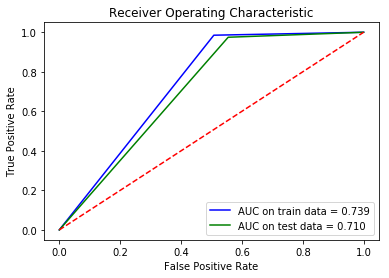

In [148]:
plotROC(fpr, tpr, fpr_test, tpr_test, auc_opt_RBFsvm_tf_tr, auc_opt_RBFlsvm_tf_test)

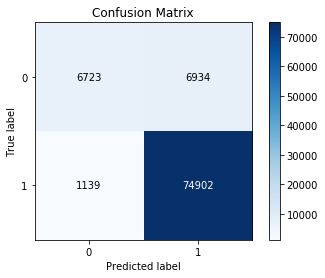

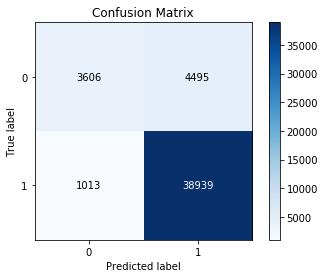

In [150]:
plotConfusion(Y_train_tf, Y_pred_tr_tf_RBFsvm,Y_test_tf,Y_pred_test_tf_RBFsvm)

In [151]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

print("Precision of test: %0.4f"%(precision_score(Y_test_tf, Y_pred_test_tf_RBFsvm)))
print("Recall of test: %0.4f"%(recall_score(Y_test_tf, Y_pred_test_tf_RBFsvm)))
print("F1 Score of test: %0.4f"%(f1_score(Y_test_tf, Y_pred_test_tf_RBFsvm)))

Precision of test: 0.8965
Recall of test: 0.9746
F1 Score of test: 0.9339


In [158]:
import pickle
filename = 'SVC_RBFSVM_tf.sav'
pickle.dump(SVC_RBFSVM_tf, open(filename, 'wb'))

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [58]:
train_sent_vectors = np.load("sent_vectors_train_aw.npy")

In [61]:
test_sent_vectors = np.load("sent_vectors_test_aw.npy")
CV_sent_vectors = np.load("sent_vectors_CV_aw.npy")
Y_train_aw_split = np.load("Y_train_split_aw.npy")
Y_test_aw = np.load("Y_test_aw.npy")
Y_CV_aw_split = np.load("Y_CV_aw.npy")

In [82]:
from sklearn.model_selection import train_test_split

X_train_aw, X_test_aw, Y_train_aw, Y_test_aw = train_test_split(preprocessed_reviews,final['Score'].values,test_size=0.3,shuffle=False)
X_train_aw_split, X_CV_aw_split, Y_train_aw_split, Y_CV_aw_split = train_test_split(X_train_aw,Y_train_aw,test_size=0.2,shuffle=False)
#print(X_train_bow.shape)
print(len(X_train_aw), len(X_test_aw),len(X_train_aw_split), len(X_CV_aw_split), len(Y_train_aw), len(Y_test_aw), len(Y_train_aw_split), len(Y_CV_aw_split))

112123 48053 89698 22425 112123 48053 89698 22425


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
auc_rsvm_aw_tr = []
auc_rsvm_aw_cv = []
XLabels = []
C_Set = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
Gamma = [0.001, 0.01, 0.1, 1, 10, 100]
Gam = 0.01
for C in tqdm(C_Set):
        temp = "G="+str(Gam)+"/ C="+str(C)
        XLabels.append(temp)
        #SVM - using SVC
        SVM_aw = SVC(kernel='rbf', random_state=0, gamma=Gam, C=C, probability=True)
        #Fit the model on train(split) data
        SVM_aw.fit(train_sent_vectors, Y_train_aw_split)
        #Predict the target value for train data
        Y_pred_RBFSVM_tr = (batch_predict(SVM_aw, train_sent_vectors))
        #Get AUC Value for train data
        temp_AUC_tr = roc_auc_score(Y_train_aw_split, Y_pred_RBFSVM_tr)
        auc_rsvm_aw_tr.append(temp_AUC_tr)
        #Predict the target value for CV data
        Y_pred_RBFSVM_cv = (batch_predict(SVM_aw, CV_sent_vectors))
        #Get AUC Value
        temp_AUC_cv = roc_auc_score(Y_CV_aw_split, Y_pred_RBFSVM_cv)
        auc_rsvm_aw_cv.append(temp_AUC_cv)
        print("For Gamma= ",Gam,"and C=",C," AUC of train data= ", temp_AUC_tr, " AUC of CV data= ", temp_AUC_cv)

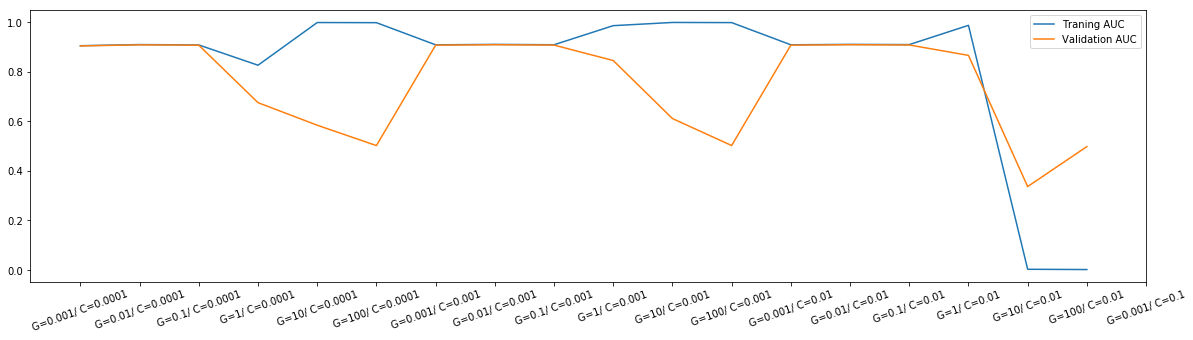

In [141]:
plt.figure(figsize=(20,5))
plt.plot(range(len(XLabels)-1), auc_rsvm_aw_tr)
plt.plot(range(len(XLabels)-1), auc_rsvm_aw_cv)
plt.xticks(range(len(XLabels)), XLabels, rotation = 20)
plt.legend(['Traning AUC', 'Validation AUC'])
plt.show()

In [ ]:
SVM_aw_opt = SVC(kernel='rbf', random_state=0, gamma=0.001, C=1, probability=True)
SVM_aw_opt.fit(train_sent_vectors, Y_train_aw_split)


In [63]:
Y_pred_tr_aw_rsvm = SVM_aw_opt.predict_proba(train_sent_vectors)[:,1]
auc_pred_tr_rsvm = roc_auc_score(Y_train_aw_split, Y_pred_tr_aw_rsvm)
Y_pred_test_aw_rsvm = SVM_aw_opt.predict_proba(test_sent_vectors)[:,1]
auc_pred_test_rsvm = roc_auc_score(Y_test_aw, Y_pred_test_aw_rsvm)
print("AUC value of train data: ",auc_pred_tr_rsvm)
print("AUC value of test data: ", auc_pred_test_rsvm)

AUC value of train data:  0.914486407428668
AUC value of test data:  0.9128569913587202


In [64]:
Y_pred_val_tr_aw_rsvm = SVM_aw_opt.predict(train_sent_vectors)
Y_pred_val_test_aw_rsvm = SVM_aw_opt.predict(test_sent_vectors)

In [70]:
auc_pred_tr_rsvm_aw = auc_pred_tr_rsvm
auc_pred_test_rsvm_aw = auc_pred_test_rsvm

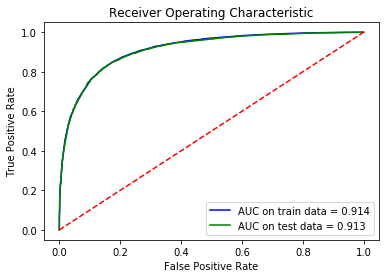

In [66]:
plotROC(Y_train_aw_split, Y_pred_tr_aw_rsvm,Y_test_aw, Y_pred_test_aw_rsvm )

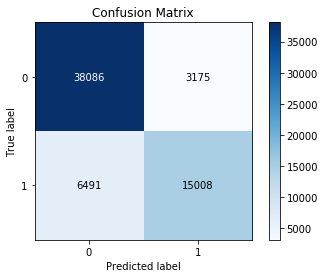

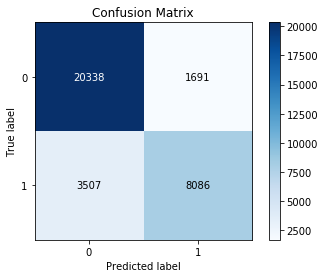

In [68]:
plotConfusion(Y_train_aw_split, Y_pred_val_tr_aw_rsvm,Y_test_aw, Y_pred_val_test_aw_rsvm)

In [177]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score, confusion_matrix

print("Precision of test: %0.4f"%(precision_score(Y_test_aw, Y_pred_test_aw_rsvm)))
print("Recall of test: %0.4f"%(recall_score(Y_test_aw, Y_pred_test_aw_rsvm)))
print("F1 Score of test: %0.4f"%(f1_score(Y_test_aw, Y_pred_test_aw_rsvm)))

Precision of test: 0.8853
Recall of test: 0.9829
F1 Score of test: 0.9315


In [69]:
import pickle
filename = 'SVM_aw_opt.sav'
pickle.dump(SVM_aw_opt, open(filename, 'wb'))

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [71]:
train_tfidf_sent_vectors = np.load("tfidf_sent_vectors_tw_train.npy")
test_tfidf_sent_vectors = np.load("tfidf_sent_vectors_tw_test.npy")
CV_tfidf_sent_vectors = np.load("tfidf_sent_vectors_tw_CV.npy")
Y_train_tw_split_part = np.load("Y_train_split_tw.npy")
Y_CV_tw_split = np.load("Y_CV_tw.npy")
Y_test_tw_split_part = np.load("Y_test_tw.npy")

In [28]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    if data.shape[0]%1000 != 0:
        tr_loop = data.shape[0] - data.shape[0]%1000
    else:
        tr_loop = data.shape[0]
    # consider you X_tr shape is 49041, then your cr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate until the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 != 0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
auc_rsvm_tw_tr = []
auc_rsvm_tw_cv = []
XLabels = []
C_Set = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
gamma = 0.01

for C in tqdm(C_Set):
        #SVM - using SVC
        SVM_tw = SVC(kernel='rbf', random_state=0, gamma=gamma, C=C, probability=True)
        #Fit the model on train(split) data
        SVM_tw.fit(train_tfidf_sent_vectors, Y_train_tw_split_part)
        #Predict the target value for train data
        Y_pred_RBFSVM_tr = (batch_predict(SVM_tw, train_tfidf_sent_vectors))
        #Get AUC Value for train data
        temp_AUC_tr = roc_auc_score(Y_train_tw_split_part, Y_pred_RBFSVM_tr)
        auc_rsvm_tw_tr.append(temp_AUC_tr)
        #Predict the target value for CV data
        Y_pred_RBFSVM_cv = (batch_predict(SVM_tw, CV_tfidf_sent_vectors))
        #Get AUC Value
        temp_AUC_cv = roc_auc_score(Y_CV_tw_split, Y_pred_RBFSVM_cv)
        auc_rsvm_tw_cv.append(temp_AUC_cv)
        print("For Gamma= ",gamma,"and C=",C," AUC of train data= ", temp_AUC_tr, " AUC of CV data= ", temp_AUC_cv)

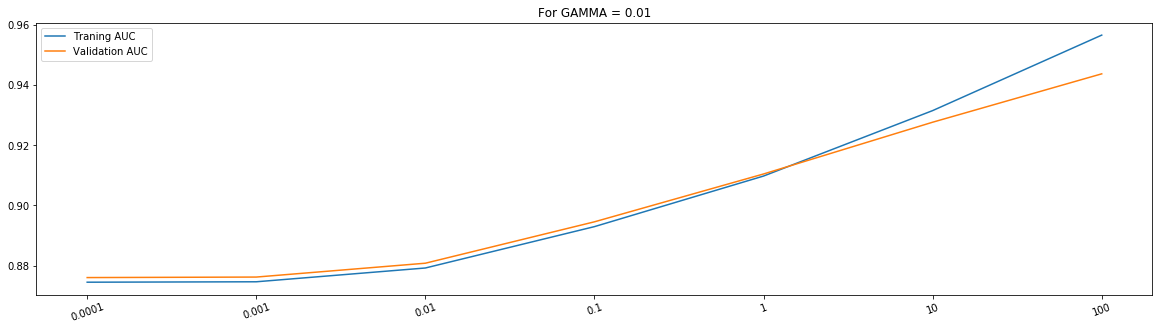

In [168]:
C_Set = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
plt.figure(figsize=(20,5))
plt.plot(range(len(C_Set)), auc_rsvm_tw_tr)
plt.plot(range(len(C_Set)), auc_rsvm_tw_cv)
plt.xticks(range(len(C_Set)), C_Set, rotation = 20)
plt.title("For GAMMA = 0.01")
plt.legend(['Traning AUC', 'Validation AUC'])
plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
SVM_tw_opt = SVC(kernel='rbf', random_state=0, gamma=0.01, C=1, probability=True)
SVM_tw_opt.fit(train_tfidf_sent_vectors, Y_train_tw_split_part)

In [30]:
from sklearn.metrics import roc_auc_score

#Predicting using "Predict_proba" - To get probability scores
Y_pred_tr_tw_rsvm = batch_predict(SVM_tw_opt, train_tfidf_sent_vectors)
auc_pred_tr_rsvm = roc_auc_score(Y_train_tw_split_part, Y_pred_tr_tw_rsvm)
Y_pred_test_tw_rsvm = batch_predict(SVM_tw_opt, test_tfidf_sent_vectors)
auc_pred_test_rsvm = roc_auc_score(Y_test_tw_split_part, Y_pred_test_tw_rsvm)
print("AUC value of train data: ",auc_pred_tr_rsvm)
print("AUC value of test data: ", auc_pred_test_rsvm)

AUC value of train data:  0.9097555356939961
AUC value of test data:  0.9077926982247985


In [40]:
#Predict using Predict()
Y_pred_val_tr_tw_rsvm = SVM_tw_opt.predict(train_tfidf_sent_vectors)
auc_pred_val_tr_rsvm = roc_auc_score(Y_train_tw_split_part, Y_pred_val_tr_tw_rsvm)
Y_pred_val_test_tw_rsvm = SVM_tw_opt.predict(test_tfidf_sent_vectors)
auc_pred_val_test_rsvm = roc_auc_score(Y_test_tw_split_part, Y_pred_val_test_tw_rsvm)

In [33]:
from sklearn.metrics import roc_curve


fpr, tpr, _ = roc_curve(Y_train_tw_split_part, Y_pred_tr_tw_rsvm)
fpr_test, tpr_test, _ = roc_curve(Y_test_tw_split_part, Y_pred_test_tw_rsvm)
auc_opt_rsvm_tw_tr = auc(fpr, tpr)
auc_opt_rsvm_tw_test = auc(fpr_test, tpr_test)
print(auc_opt_rsvm_tw_tr, auc_opt_rsvm_tw_test)

0.9097555356939961 0.9077926982247985


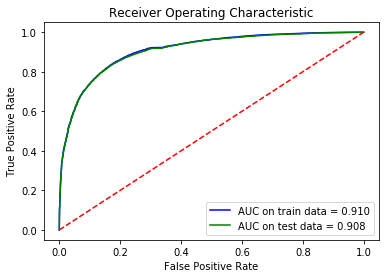

In [36]:
plotROC(Y_train_tw_split_part, Y_pred_tr_tw_rsvm, Y_test_tw_split_part, Y_pred_test_tw_rsvm)

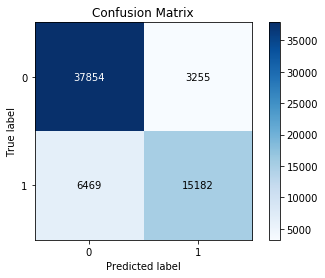

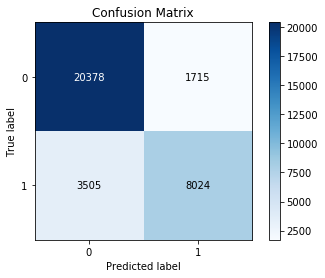

In [41]:
plotConfusion(Y_train_tw_split_part, Y_pred_val_tr_tw_rsvm, Y_test_tw_split_part, Y_pred_val_test_tw_rsvm)

In [199]:
import pickle
filename = 'SVM_tw_opt.sav'
pickle.dump(SVM_tw_opt, open(filename, 'wb'))

# [6] Conclusions

In [ ]:
from prettytable import PrettyTable
X = PrettyTable()

X.field_names = ["Kernel type","vectorizer","Alpha", "Penalty","AUC on train","AUC on Test"]
X.add_row(["Linear","BoW",0.01,"L2",auc_pred_tr_lsvm_bow,auc_pred_test_lsvm_bow])
X.add_row(["Linear","TfIdf",0.0001,"L2" ,auc_pred_tr_lsvm_tf,auc_pred_test_lsvm_tf])
X.add_row(["Linear","Avg W2V",0.001,"L2", auc_pred_tr_lsvm_aw,auc_pred_test_lsvm_aw])
X.add_row(["Linear","TfIdf W2V",0.001,"L2", auc_pred_tr_lsvm_tw, auc_pred_test_lsvm_tw])
print(X)

In [ ]:
Y = PrettyTable()
Y.field_names = ["Kernel type","vectorizer","C Value", "Gamma","AUC on train","AUC on Test"]
Y.add_row(["RBF","BoW",0.01,1,auc_pred_tr_RBFsvm_bow,auc_pred_test_RBFsvm_bow])
Y.add_row(["RBF","TfIdf",0.01,1,auc_pred_tr_RBFsvm_tf,auc_pred_test_RBFsvm_tf])
Y.add_row(["RBF","Avg W2V",0.001,1,auc_pred_tr_rsvm_aw,auc_pred_test_rsvm_aw])
Y.add_row(["RBF","TfIdf W2V",0.01,1,auc_pred_tr_rsvm_tw,auc_pred_test_rsvm_tw])
print(Y)

* In BoW-LSVM We can see huge difference between L1 and L2 regulaizer, where L1 regularizer reaches AUC of 0.5 (for alpha > 1) and L2 regulariser gives better performance compared to L1.
* Compared to Linear kernel, RBF Kernel performs well with highly-correlated-Less-Features (Avg W2V/TfIdf W2V) both on Train and Test data